## Project: Stroke prediction

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions_sandbox as sand
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.impute import SimpleImputer
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro, anderson, chi2_contingency, spearmanr, loguniform, randint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler

SyntaxError: invalid syntax (1544375995.py, line 10)

In [45]:
path = r"D:\IT_projects\Turing_Colledge\Modul3\Sprint2\project\healthcare-dataset-stroke-data.csv"
healthcare = pd.read_csv(path)

In [46]:
healthcare.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [47]:
healthcare.tail(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


Firstly let's check basic info of given data

In [48]:
healthcare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Most of Dtypes looks fine, only age Dtype could be converted to int.  
Feature named id doesn't seemed to have a value for analysis and might be  
removed.

### Data cleaning

I used my personal dataframe cleaning tool to check and clean basics of  
dataframe (duplicates, NaN, empty cells). Info=True shows what type of  
problem should be cleaned.

In [49]:
healthcare = sand.cleaner(healthcare, info=False)

Dataframe cleaner function showed that there are some NaN cells. So now let's  
check which and how many of these are

In [50]:
healthcare.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

Feature named bmi (body mass index) has NaN values that should be processed

In [51]:
healthcare["bmi"].isna().sum()

201

We can see that 201/5109 are NaN values in bmi feature which would be ~4%.  
It leaves us question what should we do with these values? The idea of dropping  
out 4% of data doesn't seem good, so I chose value imputation method.

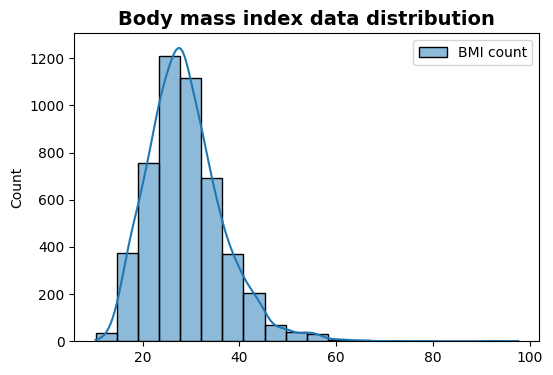

In [52]:
sand.f_histogram(
    xaxis=healthcare["bmi"],
    bins=20,
    kde=True,
    label="BMI count",
    title="Body mass index data distribution",
)

We can see BMI data is well distributed with most of the data 20-40 idx.  
Keeping this in mind we can use imputation method knowing it won't distort  
whole picture of data analysis.

In [53]:
imputer = SimpleImputer(strategy="mean")
healthcare["bmi"] = imputer.fit_transform(healthcare[["bmi"]])

After some bmi vales have been adjusted, next step is feature named age.  
It has float dtype which is usually unnecessary. Let's look why it could have  
this dtype

In [54]:
healthcare[(healthcare["age"] > 0) & (healthcare["age"] < 2)]["age"].unique()

array([1.32, 0.64, 0.88, 1.8 , 0.32, 1.08, 1.16, 1.  , 1.4 , 1.72, 0.24,
       1.64, 1.56, 0.72, 1.88, 1.24, 0.8 , 0.4 , 0.08, 1.48, 0.56, 0.48,
       0.16])

Apparently, most of the age values are whole numbers except numbers from  
0 to 2. Values in this interval are extracted to decimals. For now, I will  
convert these numbers to integers. If any interesting results would be seen  
in further analysis, these values (1, 2) will be reversed to floats for deeper  
analysis

In [55]:
# Copy of healthcare dataframe
hc = healthcare.copy()

hc["age"] = hc["age"].astype(int)

In [56]:
hc["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

We see value Other in feature named Gender. Because it's only one row  
and will not have strong impact to analysis, it can be removed

In [57]:
hc = hc.loc[hc["gender"] != "Other"]

In [58]:
hc["work_type"].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

We can see on work type feature there are 5 string typeclasses. We can clean  
them to be more convenient to work with.  
Also, I checked smoking status value numbers and strings looks

In [59]:
# replace column's strings
hc["work_type"] = hc["work_type"].replace(
    {
        "Private": "private",
        "Self-employed": "self_employed",
        "Govt_job": "gvt_job",
        "children": "child_care",
        "Never_worked": "never_worked",
    }
)

# count values of each column's class
hc["smoking_status"].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

We can see 4 classes of smoking status feature with the first place  
never_smoked and second unknown. The unknown class might be a problem in  
further research if smoking status feature had strong impact to ML models.

In [60]:
# replace column's strings
hc["smoking_status"] = hc["smoking_status"].replace(
    {
        "formerly smoked":"fmly_smoked",
        "never smoked":"never_smoked",
        "smokes":"smokes",
        "Unknown":"unknown"
    }
)

# id column drop
hc = hc.drop(columns="id")

# lower case strings
hc["residence_type"] = hc["residence_type"].str.lower()
hc["gender"] = hc["gender"].str.lower()

### EDA (Exploratory Data Analysis)

Since I did some changes in dataframe, let's check again basic info of cleaned  
dataframe

In [61]:
hc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   int32  
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(2), int32(1), int64(3), object(5)
memory usage: 459.0+ KB


By looking into table we can split data to categorical and numerical for  
future analysis

In [62]:
numeric = ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "stroke"]
categoric = ["gender", "ever_married", "work_type", "residence_type", "smoking_status"]
hc_num = hc[numeric]
hc_cat = hc[categoric]

Let's describe numeric values

In [63]:
hc.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5109.0,43.218634,22.634799,0.00,25.00,45.00,61.00,82.00
hypertension,5109.0,0.097475,0.296633,0.00,0.00,0.00,0.00,1.00
heart_disease,5109.0,0.054022,0.226084,0.00,0.00,0.00,0.00,1.00
avg_glucose_level,5109.0,106.140399,45.285004,55.12,77.24,91.88,114.09,271.74
bmi,5109.0,28.894508,7.698235,10.30,23.80,28.40,32.80,97.60
stroke,5109.0,0.048738,0.215340,0.00,0.00,0.00,0.00,1.00


We can see avg. age is 43 with min 0 (less than 1 year) and max 82.  
Glucose level has quite a high interval 55 - 271 with mean around 106.  
BMI mean is ~29 where 50% of data points are also near 28

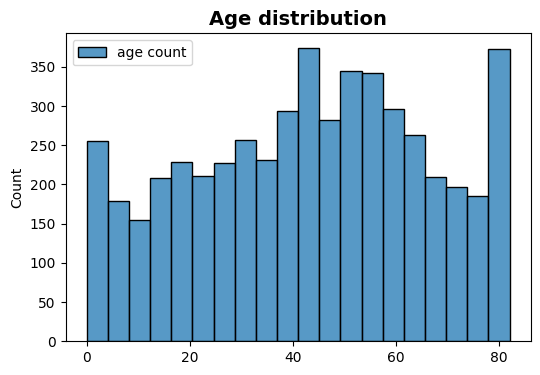

In [64]:
sand.f_histogram(xaxis=hc["age"], label="age count", title="Age distribution")

Age distribution plot shows the most data points are in 40-60 age and two  
annomaly for normal distribution ~80 years people. Children 0-2 have higher  
data count due to float convertion to 1 and 2 at the beginning of the study

To look closer into data and check if data is distributed normally,  
Anderson-Darling test was performed with null hypothesis:  
alpha=0.05  
**H0**: *stat < crit. vals, suggests that data is normally distributed*  
**Ha**: *stat > crit. vals, suggests that data is NOT normally distributed*

In [104]:
result = anderson(hc["age"], dist="norm")
print(f"Statistic = {result.statistic:.4f}")
print(f"Critical values (15%, 10%, 5%, 2.5%, 1%): {result.critical_values}")

Statistic = 33.4629
Critical values (15%, 10%, 5%, 2.5%, 1%): [0.576 0.655 0.786 0.917 1.091]


The test statistic is larger than the critical value at all significance  
levels. With that result we reject null hypothesis, meaning data likely does  
NOT follow the specified distribution. It is visually shown with Q-Q plot  
as well at the following cell

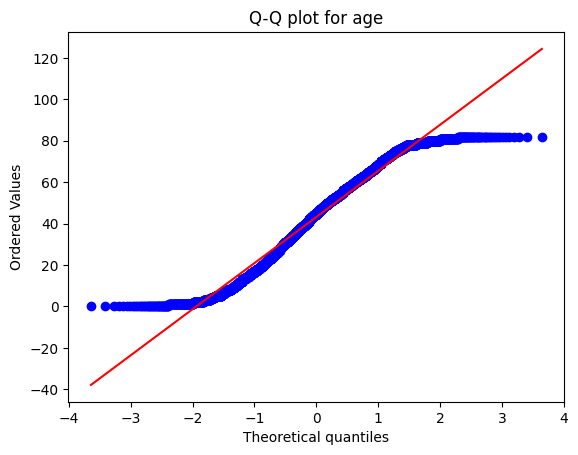

In [90]:
stats.probplot(hc["age"], dist="norm", plot=plt)
plt.title("Q-Q plot for age")
plt.show()

We can also check age data distribution per gender, to see if data is similary  
distributed around both genders

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(1, 0, '2994')

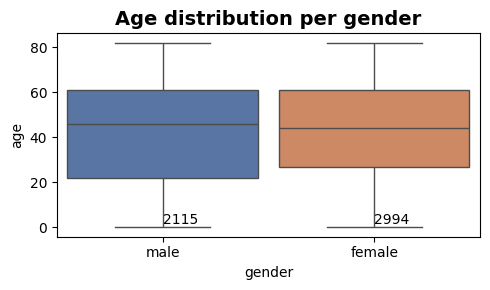

In [87]:
gend = hc["gender"].value_counts()
sand.f_boxplot(
    data=hc,
    xaxis="gender",
    yaxis="age",
    hue="gender",
    ylabel="age",
    title="Age distribution per gender"
)
plt.text(0, hc["age"].min(), f"{gend.loc['male']}", ha="left", va="bottom")
plt.text(1, hc["age"].min(), f"{gend.loc['female']}", ha="left", va="bottom")

Plot shows male and female distribution is similar. Female distribution is  
a little bit narrower and it has almost 800 more data points. Such unequality  
might have impact for ML models where these could calculate resuls on female  
class favor due to higher amount of data points